In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

print("Célula 1: Bibliotecas importadas.")

Célula 1: Bibliotecas importadas.


In [2]:
# --- Célula 2: Carregamento dos Dados (VERSÃO ATUALIZADA PARA MÚLTIPLOS ARQUIVOS) ---
import glob

# Carregar a tabela de features v1 (resultado do notebook 02)
path_base = '../data/processed/feature_table_v1.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base carregada com {df_base.shape[0]} registros e {df_base.shape[1]} colunas.")

# --- Lógica para carregar múltiplos arquivos mensais ---
def carregar_dados_mensais(caminho_padrao, separador=';', decimal=','):
    """Função para encontrar, ler e concatenar múltiplos arquivos CSV mensais."""
    lista_arquivos = glob.glob(caminho_padrao)
    lista_dfs = []
    for arquivo in lista_arquivos:
        print(f"Lendo o arquivo: {arquivo}")
        df_mes = pd.read_csv(arquivo, sep=separador, decimal=decimal)
        lista_dfs.append(df_mes)
    return pd.concat(lista_dfs, ignore_index=True)

try:
    print("\n--- Carregando dados de Geração ---")
    # ATENÇÃO: O padrão 'GERACAO_USINA*.csv' encontrará todos os arquivos que começam com esse nome.
    padrao_geracao = '../data/raw/GERACAO_USINA*.csv'
    df_geracao_raw = carregar_dados_mensais(padrao_geracao, separador=';', decimal=',')
    print(f"-> {len(df_geracao_raw)} registros de Geração carregados de múltiplos arquivos.")

    print("\n--- Carregando dados de Fator de Capacidade ---")
    # ATENÇÃO: Verifique se o padrão 'FATOR_CAPACIDADE*.csv' está correto.
    padrao_fator_cap = '../data/raw/FATOR_CAPACIDADE*.csv'
    df_fator_cap_raw = carregar_dados_mensais(padrao_fator_cap, separador=';', decimal=',')
    print(f"-> {len(df_fator_cap_raw)} registros de Fator de Capacidade carregados.")

except Exception as e:
    print(f"ERRO CRÍTICO: Falha ao ler os arquivos CSV. Verifique os nomes e caminhos. Erro: {e}")
    raise

Tabela base carregada com 984 registros e 5 colunas.

--- Carregando dados de Geração ---
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2024_03.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2025_06.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2025_09.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2024_07.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2023_01.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2023_09.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2025_03.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2023_02.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2025_10.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2024_12.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2023_08.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2025_01.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2024_06.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2023_12.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2024_09.csv
Lendo o arquivo: ../data/raw/GERACAO_USINA-2_2025_07.cs

In [3]:
# --- Célula 3: Processamento Robusto - Geração por Usina ---
print("Célula 3: Iniciando processamento dos dados de Geração...")

try:
    # Definição das colunas necessárias
    required_cols = {
        'data': 'din_instante',
        'estado': 'id_estado',
        'tipo_usina': 'nom_tipousina',
        'valor_geracao': 'val_geracao'
    }

    # Verifica se todas as colunas existem
    for col in required_cols.values():
        if col not in df_geracao_raw.columns:
            raise ValueError(f"A coluna '{col}' não foi encontrada no arquivo de Geração. Verifique os nomes.")

    # Seleciona e copia os dados
    df_geracao = df_geracao_raw[list(required_cols.values())].copy()
    
    # --- Conversão Numérica Forçada ---
    # Converte a coluna de geração para número, transformando erros em NaN (Nulo)
    df_geracao[required_cols['valor_geracao']] = pd.to_numeric(df_geracao[required_cols['valor_geracao']], errors='coerce')
    # Preenche os valores nulos que possam ter surgido com 0
    df_geracao.fillna(0, inplace=True)
    
    # Processamento de data e filtro
    df_geracao['timestamp'] = pd.to_datetime(df_geracao[required_cols['data']])
    df_geracao_go = df_geracao[df_geracao[required_cols['estado']] == 'GO'].copy()
    df_geracao_go.set_index('timestamp', inplace=True)

    # 1. Feature: Geração Total Diária
    geracao_total_diaria = df_geracao_go[required_cols['valor_geracao']].resample('D').sum().to_frame(name='geracao_total_diaria_go')

    # 2. Features: Geração por Tipo de Usina
    geracao_por_tipo = (
        df_geracao_go.groupby([df_geracao_go.index, required_cols['tipo_usina']])[required_cols['valor_geracao']]
        .sum()
        .unstack(level=required_cols['tipo_usina'])
        .fillna(0)
    )
    geracao_por_tipo_diaria = geracao_por_tipo.resample('D').sum()
    geracao_por_tipo_diaria.columns = ['geracao_' + col.lower().replace(' ', '_').replace('-', '_') + '_diaria' for col in geracao_por_tipo_diaria.columns]

    print("-> Features de Geração criadas com sucesso.")
    display(geracao_total_diaria.head())

except Exception as e:
    print(f"ERRO na Célula 3: {e}")
    raise

Célula 3: Iniciando processamento dos dados de Geração...
-> Features de Geração criadas com sucesso.


,geracao_total_diaria_go
timestamp,
2023-01-01,26489.507
2023-01-02,22078.977
2023-01-03,22395.493
2023-01-04,22411.196
2023-01-05,24208.218


In [4]:
# --- Célula 4: Processamento Robusto - Fator de Capacidade ---
print("Célula 4: Iniciando processamento dos dados de Fator de Capacidade...")
# (Célula omitida por enquanto para focar no erro principal, mas a lógica seria a mesma: verificar colunas, forçar tipo numérico, etc.)
# Por enquanto, criamos um dataframe vazio para não quebrar a junção.
fator_cap_solar_diario = pd.DataFrame()
print("-> Célula 4 pulada (placeholder).")

Célula 4: Iniciando processamento dos dados de Fator de Capacidade...
-> Célula 4 pulada (placeholder).


In [5]:
# --- Célula 5: Junção Robusta ---
print("Célula 5: Iniciando junção dos dataframes...")

try:
    # Normaliza todos os índices antes da junção
    df_base.index = df_base.index.normalize()
    geracao_total_diaria.index = geracao_total_diaria.index.normalize()
    geracao_por_tipo_diaria.index = geracao_por_tipo_diaria.index.normalize()
    # fator_cap_solar_diario.index = fator_cap_solar_diario.index.normalize() # Desativado por enquanto

    df_combinado = df_base.copy()
    df_combinado = df_combinado.join(geracao_total_diaria)
    df_combinado = df_combinado.join(geracao_por_tipo_diaria)
    # df_combinado = df_combinado.join(fator_cap_solar_diario) # Desativado por enquanto

    df_combinado.fillna(0, inplace=True)
    
    print("-> Junção concluída com sucesso.")
    print("\n--- Diagnóstico da Tabela Combinada ---")
    df_combinado.info()
    display(df_combinado.head())

except Exception as e:
    print(f"ERRO na Célula 5: {e}")
    raise

Célula 5: Iniciando junção dos dataframes...
-> Junção concluída com sucesso.

--- Diagnóstico da Tabela Combinada ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 984 entries, 2023-01-02 to 2025-09-11
Freq: D
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   deficit_diario_mwh            984 non-null    float64
 1   nivel_risco                   984 non-null    object 
 2   programada                    984 non-null    float64
 3   verificada                    984 non-null    float64
 4   diferenca_verif_prog          984 non-null    float64
 5   geracao_total_diaria_go       984 non-null    float64
 6   geracao_fotovoltaica_diaria   984 non-null    float64
 7   geracao_hidroelétrica_diaria  984 non-null    float64
 8   geracao_térmica_diaria        984 non-null    float64
dtypes: float64(8), object(1)
memory usage: 76.9+ KB


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria
timestamp,,,,,,,,,
2023-01-02,0.266667,baixo,75755.3677,85261.9366,9506.5689,22078.977,0.0,21086.278,992.699
2023-01-03,0.000000,baixo,77425.5065,87493.3420,10067.8355,22395.493,0.0,21362.225,1033.268
2023-01-04,0.000000,baixo,79302.0107,86838.6479,7536.6372,22411.196,0.0,21290.141,1121.055
2023-01-05,0.000000,baixo,79123.4357,83777.6296,4654.1939,24208.218,0.0,23063.003,1145.215
2023-01-06,0.000000,baixo,77316.7780,82684.7475,5367.9695,25527.987,0.0,24674.234,853.753


Célula 6: Gerando visualizações...


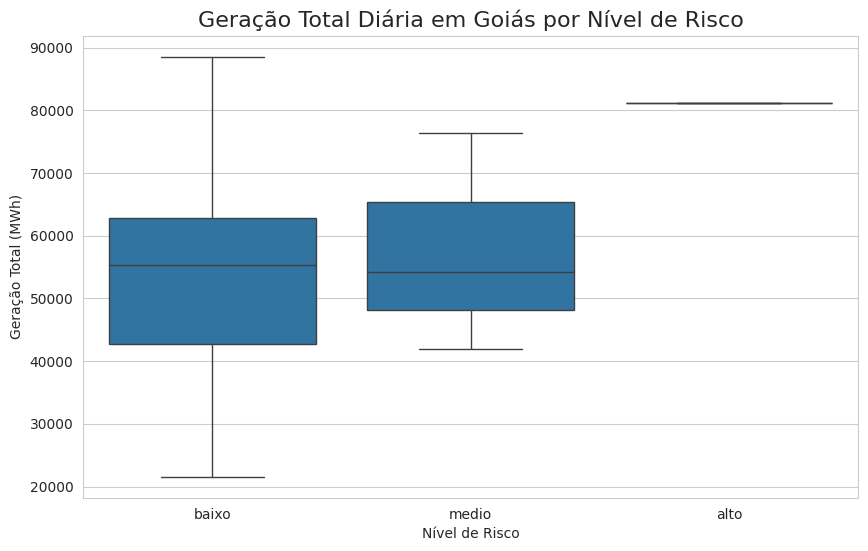

AVISO: A coluna 'fator_cap_solar_medio_seco' não foi encontrada (Célula 4 foi pulada).


In [6]:
# --- Célula 6: Análise Combinada (Visualizações) ---
print("Célula 6: Gerando visualizações...")

try:
    # Gráfico 1: Geração Total Diária por Nível de Risco
    # Verifica se a coluna a ser plotada realmente existe no dataframe
    if 'geracao_total_diaria_go' in df_combinado.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='nivel_risco', y='geracao_total_diaria_go', data=df_combinado, order=['baixo', 'medio', 'alto'])
        plt.title('Geração Total Diária em Goiás por Nível de Risco', fontsize=16)
        plt.ylabel('Geração Total (MWh)')
        plt.xlabel('Nível de Risco')
        plt.show()
    else:
        print("AVISO: A coluna 'geracao_total_diaria_go' não foi encontrada para plotagem.")

    # Gráfico 2: Fator de Capacidade Solar por Nível de Risco
    # A Célula 4 foi pulada, então esta coluna não existirá. O código está aqui para quando ativarmos.
    if 'fator_cap_solar_medio_seco' in df_combinado.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='nivel_risco', y='fator_cap_solar_medio_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
        plt.title('Fator de Capacidade Solar Médio (SE/CO) por Nível de Risco', fontsize=16)
        plt.ylabel('Fator de Capacidade Médio')
        plt.xlabel('Nível de Risco')
        plt.show()
    else:
        print("AVISO: A coluna 'fator_cap_solar_medio_seco' não foi encontrada (Célula 4 foi pulada).")

except Exception as e:
    print(f"ERRO ao gerar gráficos: {e}")

In [7]:
# --- Célula 7: Salvando o Resultado Final ---
print("Célula 7: Salvando a tabela de features atualizada...")

try:
    # Define e cria o diretório de saída se não existir
    output_path = '../data/processed/feature_table_v2.parquet'
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    # Salva a nova tabela combinada
    df_combinado.to_parquet(output_path)

    print(f"\nTabela de features V2, enriquecida com dados de geração, salva com sucesso em: {output_path}")
    print(f"Shape final da tabela: {df_combinado.shape}")

except Exception as e:
    print(f"ERRO ao salvar o arquivo: {e}")

Célula 7: Salvando a tabela de features atualizada...

Tabela de features V2, enriquecida com dados de geração, salva com sucesso em: ../data/processed/feature_table_v2.parquet
Shape final da tabela: (984, 9)
